In [15]:
# ============================================================
# Final Project
# ============================================================

DEMO = False

import os
import glob
from io import BytesIO

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageFilter, ImageEnhance

import torch
from torch import nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import Dataset, Subset
from sklearn.metrics import classification_report, confusion_matrix

# ------------------------------------------------------------
# Device
# ------------------------------------------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cpu


Trainloader loaded: 844
Valloader loaded: 94


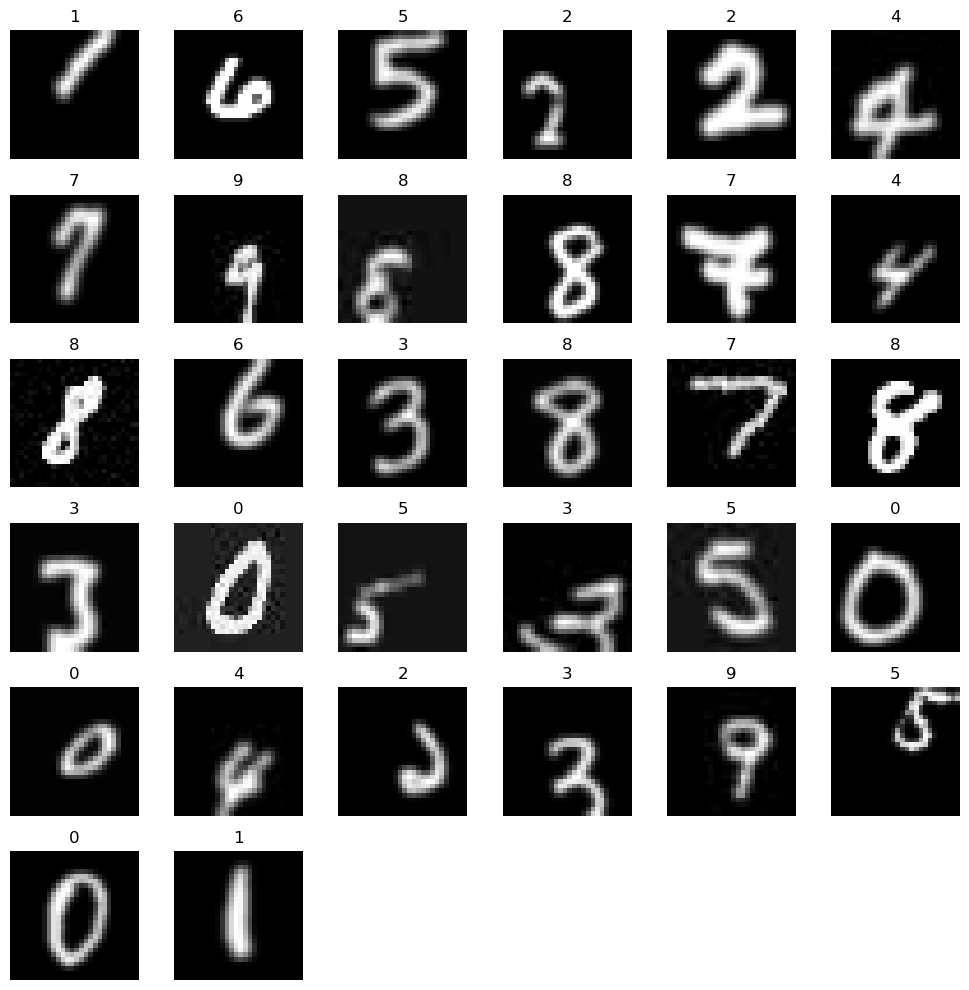

In [24]:

# ============================================================
# 1. Data and augmentation setup
# ============================================================


class RaiseDarkPoint(object):
    def __init__(self, grayRange=(10, 60)):
        self.grayRange = grayRange

    def __call__(self, img):
        arr = np.array(img).astype(np.float32)
        grayVal = np.random.uniform(*self.grayRange)
        mask = arr < 30
        arr[mask] = arr[mask] + grayVal
        arr = np.clip(arr, 0, 255)
        return Image.fromarray(arr.astype(np.uint8), mode="L")


class LowerWhitePoint(object):
    def __init__(self, factorRange=(0.7, 0.95)):
        self.factorRange = factorRange

    def __call__(self, img):
        arr = np.array(img, dtype=np.float32)
        factor = float(np.random.uniform(self.factorRange[0], self.factorRange[1]))
        arr = arr * factor
        arr = np.clip(arr, 0, 255)
        return Image.fromarray(arr.astype(np.uint8), mode="L")


class AddNoise(object):
    def __init__(self, noiseStd=0.05):
        self.noiseStd = noiseStd

    def __call__(self, img):
        arr = np.array(img).astype(np.float32)
        noise = np.random.normal(0, self.noiseStd * 255, arr.shape)
        arr = arr + noise
        arr = np.clip(arr, 0, 255)
        return Image.fromarray(arr.astype(np.uint8), mode="L")


class BubblyDigits(object):
    def __init__(self, blurRange=(0.4, 1.0), contrastRange=(1.1, 1.6)):
        self.blurRange = blurRange
        self.contrastRange = contrastRange

    def __call__(self, img):
        sigma = float(np.random.uniform(self.blurRange[0], self.blurRange[1]))
        img = img.filter(ImageFilter.GaussianBlur(radius=sigma))
        c = float(np.random.uniform(self.contrastRange[0], self.contrastRange[1]))
        img = ImageEnhance.Contrast(img).enhance(c)
        return img


class JPEGCompression(object):
    def __init__(self, qualityRange=(40, 80)):
        self.qualityRange = qualityRange

    def __call__(self, img):
        q = int(np.random.randint(self.qualityRange[0], self.qualityRange[1]))
        buf = BytesIO()
        img.save(buf, format="JPEG", quality=q)
        buf.seek(0)
        return Image.open(buf).convert("L")


trainTransform = transforms.Compose(
    [
        transforms.RandomApply(
            [
                transforms.Pad(4, fill=0),
                transforms.RandomCrop(28),
            ],
            p=0.5,
        ),
        transforms.RandomApply(
            [
                transforms.RandomAffine(
                    degrees=(-5, 20),
                    translate=(0.25, 0.25),
                    scale=(0.6, 1.1),
                    fill=0,
                )
            ],
            p=0.5,
        ),
        transforms.RandomApply([AddNoise()], p=0.1),
        transforms.RandomApply([BubblyDigits()], p=0.5),
        transforms.RandomApply([LowerWhitePoint()], p=0.4),
        transforms.RandomApply([RaiseDarkPoint()], p=0.4),
        transforms.RandomApply(
            [transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 1.5))], p=1
        ),
        transforms.RandomApply([JPEGCompression()], p=0.25),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,)),
    ]
)

transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))]
)


def ColorStretch(image):
    if image.mode != "RGB":
        image = image.convert("RGB")

    blurred = image.filter(ImageFilter.GaussianBlur(radius=0.75))
    arr = np.array(blurred).astype(np.float32)
    gray = arr.mean(axis=2)

    minVal = gray.min()
    maxVal = gray.max()

    if maxVal - minVal < 1e-6:
        stretched = np.zeros_like(gray)
    else:
        stretched = (gray - minVal) / (maxVal - minVal) * 255.0

    stretched = stretched.astype(np.uint8)
    return Image.fromarray(stretched, mode="L")


# -----------------------------
# MNIST train/val/test split
# -----------------------------
fullTrainAug = datasets.MNIST(
    "~/.pytorch/MNIST_data/", download=True, train=True, transform=trainTransform
)
fullTrainPlain = datasets.MNIST(
    "~/.pytorch/MNIST_data/", download=True, train=True, transform=transform
)

trainSize = int(0.9 * len(fullTrainAug))
valSize = len(fullTrainAug) - trainSize

indices = torch.randperm(len(fullTrainAug)).tolist()
trainIdx = indices[:trainSize]
valIdx = indices[trainSize:]

trainSet = Subset(fullTrainAug, trainIdx)   # with augmentation
valSet = Subset(fullTrainPlain, valIdx)     # no augmentation

trainLoader = torch.utils.data.DataLoader(trainSet, batch_size=64, shuffle=True)
valLoader = torch.utils.data.DataLoader(valSet, batch_size=64, shuffle=False)

testSet = datasets.MNIST(
    "~/.pytorch/MNIST_data/", download=True, train=False, transform=transform
)
testLoader = torch.utils.data.DataLoader(testSet, batch_size=64, shuffle=False)

print("Trainloader loaded:", len(trainLoader))
print("Valloader loaded:", len(valLoader))

dataIter = iter(trainLoader)
imgs, labels = next(dataIter)
imgsVis = imgs * 0.5 + 0.5

plt.figure(figsize=(10, 10))
for i in range(32):
    plt.subplot(6, 6, i + 1)
    plt.imshow(imgsVis[i].squeeze().cpu(), cmap="gray")
    plt.title(labels[i].item())
    plt.axis("off")
plt.tight_layout()
plt.show(block=False)
plt.pause(0.001)




In [17]:
# ============================================================
# 2. Model definition
# ============================================================


class MNISTMLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 512)
        self.bn1 = nn.BatchNorm1d(512)
        self.fc2 = nn.Linear(512, 256)
        self.bn2 = nn.BatchNorm1d(256)
        self.fc3 = nn.Linear(256, 128)
        self.bn3 = nn.BatchNorm1d(128)
        self.fc4 = nn.Linear(128, 10)
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        x = x.view(x.shape[0], -1)
        x = F.relu(self.bn1(self.fc1(x)))
        x = self.dropout(x)
        x = F.relu(self.bn2(self.fc2(x)))
        x = self.dropout(x)
        x = F.relu(self.bn3(self.fc3(x)))
        x = self.fc4(x)
        return x


model = MNISTMLP().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=5e-4, weight_decay=1e-4)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    factor=0.5,
    patience=5,
)

print(model)


MNISTMLP(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (bn1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (bn2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=256, out_features=128, bias=True)
  (bn3): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc4): Linear(in_features=128, out_features=10, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)


Epoch 1/100, Train Loss: 1.2846, Val Loss: 0.2421 Learning Rate: 0.000500
Epoch 2/100, Train Loss: 0.8823, Val Loss: 0.1809 Learning Rate: 0.000500
Epoch 3/100, Train Loss: 0.7666, Val Loss: 0.1505 Learning Rate: 0.000500
Epoch 4/100, Train Loss: 0.6978, Val Loss: 0.1815 Learning Rate: 0.000500
Epoch 5/100, Train Loss: 0.6495, Val Loss: 0.1450 Learning Rate: 0.000500
Epoch 6/100, Train Loss: 0.6134, Val Loss: 0.1483 Learning Rate: 0.000500
Epoch 7/100, Train Loss: 0.5873, Val Loss: 0.1116 Learning Rate: 0.000500
Epoch 8/100, Train Loss: 0.5641, Val Loss: 0.1211 Learning Rate: 0.000500
Epoch 9/100, Train Loss: 0.5418, Val Loss: 0.0778 Learning Rate: 0.000500
Epoch 10/100, Train Loss: 0.5210, Val Loss: 0.0787 Learning Rate: 0.000500
Epoch 11/100, Train Loss: 0.5187, Val Loss: 0.0878 Learning Rate: 0.000500
Epoch 12/100, Train Loss: 0.5076, Val Loss: 0.0991 Learning Rate: 0.000500
Epoch 13/100, Train Loss: 0.4917, Val Loss: 0.0768 Learning Rate: 0.000500
Epoch 14/100, Train Loss: 0.4822, 

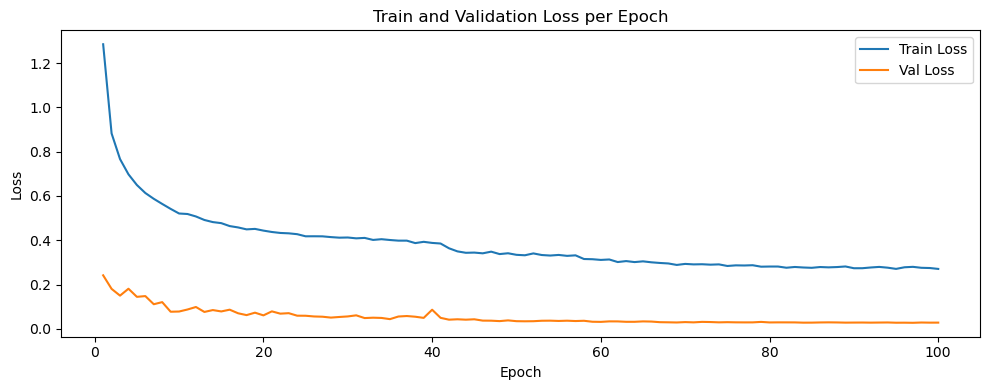

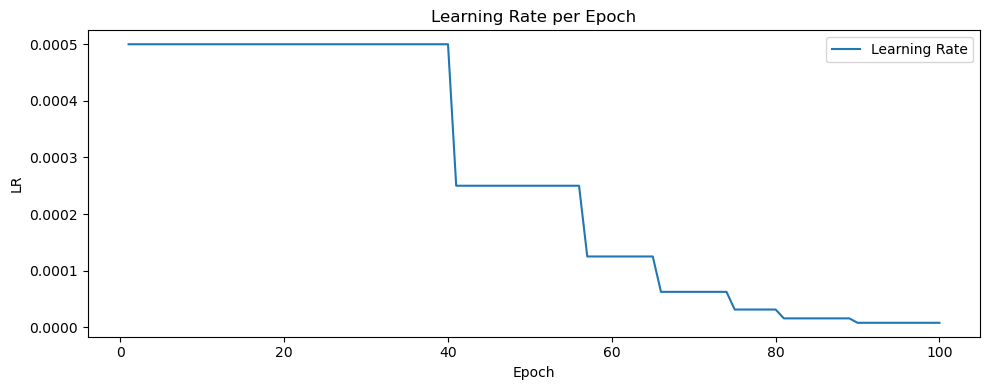

In [18]:
# ============================================================
# 3. Training + validation loop
# ============================================================

if not DEMO:
    numEpochs = 100
    epochTrainLosses = []
    valLosses = []
    learningRates = []

    for epoch in range(numEpochs):
        model.train()
        runningLoss = 0.0

        for images, labels in trainLoader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            logits = model(images)
            loss = criterion(logits, labels)
            loss.backward()
            optimizer.step()

            runningLoss += loss.item()

        epochLoss = runningLoss / len(trainLoader)
        epochTrainLosses.append(epochLoss)

        # validation loss
        model.eval()
        valRunningLoss = 0.0
        with torch.no_grad():
            for images, labels in valLoader:
                images, labels = images.to(device), labels.to(device)
                logits = model(images)
                loss = criterion(logits, labels)
                valRunningLoss += loss.item()

        valLoss = valRunningLoss / len(valLoader)
        valLosses.append(valLoss)

        scheduler.step(valLoss)
        currentLr = optimizer.param_groups[0]["lr"]
        learningRates.append(currentLr)

        print(
            f"Epoch {epoch+1}/{numEpochs}, "
            f"Train Loss: {epochLoss:.4f}, Val Loss: {valLoss:.4f} "
            f"Learning Rate: {currentLr:.6f}"
        )

    print("Training complete.")

    epochs = range(1, numEpochs + 1)

    plt.figure(figsize=(10, 4))
    plt.plot(epochs, epochTrainLosses, label="Train Loss")
    plt.plot(epochs, valLosses, label="Val Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Train and Validation Loss per Epoch")
    plt.legend()
    plt.tight_layout()
    plt.show(block=False)
    plt.pause(0.001)


    # Learning rate per epoch
    plt.figure(figsize=(10, 4))
    plt.plot(epochs, learningRates, label="Learning Rate")
    plt.xlabel("Epoch")
    plt.ylabel("LR")
    plt.title("Learning Rate per Epoch")
    plt.legend()
    plt.tight_layout()
    plt.show(block=False)
    plt.pause(0.001)


    torch.save(model.state_dict(), "model.pth")
else:
    # DEMO mode
    model.load_state_dict(torch.load("model.pth", map_location=device))
    model.eval()
    print("Loaded model.pth (DEMO mode)")



==== MNIST Test Set RESULTS ====
Accuracy: 0.9915
Error Rate: 0.0085

Classification Report:
              precision    recall  f1-score   support

           0     0.9929    0.9990    0.9959       980
           1     0.9930    0.9974    0.9952      1135
           2     0.9894    0.9932    0.9913      1032
           3     0.9970    0.9881    0.9925      1010
           4     0.9878    0.9919    0.9898       982
           5     0.9911    0.9955    0.9933       892
           6     0.9958    0.9896    0.9927       958
           7     0.9826    0.9912    0.9869      1028
           8     0.9969    0.9887    0.9928       974
           9     0.9890    0.9802    0.9846      1009

    accuracy                         0.9915     10000
   macro avg     0.9916    0.9915    0.9915     10000
weighted avg     0.9915    0.9915    0.9915     10000

Confusion Matrix:
[[ 979    0    0    0    0    0    0    1    0    0]
 [   0 1132    1    0    0    0    1    1    0    0]
 [   1    1 1025    0  

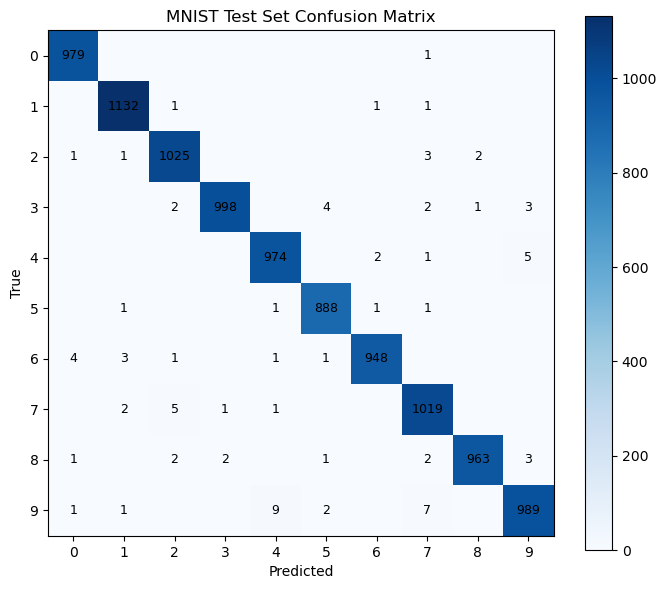

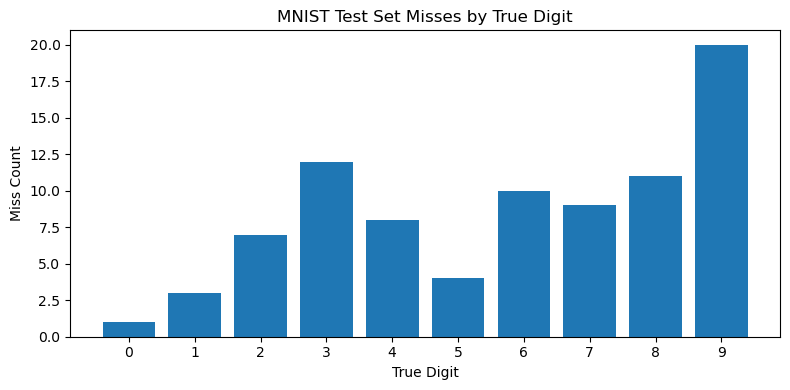


MNIST Test Set mispredictions: 85 / 10000
(No file paths available to print per-image misses.)
MNIST test accuracy (float): 0.9915


In [19]:
# ============================================================
# 4. Evaluation helpers
# ============================================================

def PlotConfusionMatrix(cm, title):
    plt.figure(figsize=(7, 6))
    plt.imshow(cm, interpolation="nearest", cmap="Blues")
    plt.title(f"{title} Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.xticks(range(10))
    plt.yticks(range(10))
    plt.colorbar()
    for r in range(cm.shape[0]):
        for c in range(cm.shape[1]):
            v = cm[r, c]
            if v != 0:
                plt.text(c, r, str(v), ha="center", va="center", fontsize=9)
    plt.tight_layout()
    plt.show(block=False)
    plt.pause(0.001)

def PlotMissesByDigit(allPreds, allLabels, title):
    misses = []
    for d in range(10):
        misses.append(int(np.sum((allLabels == d) & (allPreds != d))))

    plt.figure(figsize=(8, 4))
    plt.bar(range(10), misses)
    plt.title(f"{title} Misses by True Digit")
    plt.xlabel("True Digit")
    plt.ylabel("Miss Count")
    plt.xticks(range(10))
    plt.tight_layout()
    plt.show(block=False)
    plt.pause(0.001)

def PlotGroupAccuracy(allPreds, allLabels, allGroupIDs, title):
    valid = allGroupIDs >= 0
    if not np.any(valid):
        return

    groupAcc = {}
    for gid in np.unique(allGroupIDs[valid]):
        mask = (allGroupIDs == gid)
        groupAcc[gid] = float(np.mean(allPreds[mask] == allLabels[mask]))

    groups = list(groupAcc.keys())
    accs = [groupAcc[g] for g in groups]

    plt.figure(figsize=(10, 5))
    plt.bar([str(g) for g in groups], accs)
    plt.ylim(0, 1.05)
    plt.xlabel("Group ID")
    plt.ylabel("Accuracy")
    plt.title(f"{title} Accuracy by Group")
    plt.tight_layout()
    plt.show(block=False)
    plt.pause(0.001)

def PrintMispredictions(allPreds, allLabels, allPaths, title, maxMisses=None):
    missIdx = np.where(allPreds != allLabels)[0]
    print(f"\n{title} mispredictions: {len(missIdx)} / {len(allLabels)}")

    if len(allPaths) != len(allLabels):
        print("(No file paths available to print per-image misses.)")
        return

    shown = 0
    for i in missIdx:
        print(f"- {allPaths[i]} | true={int(allLabels[i])} pred={int(allPreds[i])}")
        shown += 1
        if maxMisses is not None and shown >= maxMisses:
            print(f"... truncated at {maxMisses} misses")
            break



def EvaluateWithDetails(loader, name="Dataset", plot=True, printMisses=True, maxMisses=None):
    model.eval()
    allPreds, allLabels = [], []
    allGroupIDs = []
    allPaths = []

    with torch.no_grad():
        for data in loader:
            if len(data) == 4:
                images, labels, group_ids, paths = data
                allGroupIDs.extend(group_ids.cpu().numpy())
                allPaths.extend(list(paths))
            elif len(data) == 3:
                images, labels, group_ids = data
                allGroupIDs.extend(group_ids.cpu().numpy())
            elif len(data) == 2:
                images, labels = data
            else:
                continue

            images, labels = images.to(device), labels.to(device)
            logits = model(images)
            _, preds = torch.max(logits, 1)

            allPreds.extend(preds.cpu().numpy())
            allLabels.extend(labels.cpu().numpy())

    allPreds = np.array(allPreds)
    allLabels = np.array(allLabels)
    allGroupIDs = np.array(allGroupIDs) if len(allGroupIDs) == len(allLabels) else None

    accuracy = (allPreds == allLabels).mean()
    errorRate = 1.0 - accuracy

    print(f"\n==== {name} RESULTS ====")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Error Rate: {errorRate:.4f}")
    print("\nClassification Report:")
    print(classification_report(allLabels, allPreds, digits=4))

    cm = confusion_matrix(allLabels, allPreds)
    print("Confusion Matrix:")
    print(cm)

    if plot:
        PlotConfusionMatrix(cm, name)
        PlotMissesByDigit(allPreds, allLabels, name)
        if allGroupIDs is not None and np.any(allGroupIDs >= 0):
            PlotGroupAccuracy(allPreds, allLabels, allGroupIDs, name)

    if printMisses:
        PrintMispredictions(allPreds, allLabels, allPaths, name, maxMisses=maxMisses)

    return accuracy


mnistAcc = EvaluateWithDetails(testLoader, "MNIST Test Set")
print("MNIST test accuracy (float):", float(mnistAcc))


Handwritten digits found: 330

==== Handwritten Digits RESULTS ====
Accuracy: 0.9576
Error Rate: 0.0424

Classification Report:
              precision    recall  f1-score   support

           0     0.8462    1.0000    0.9167        33
           1     1.0000    0.9394    0.9688        33
           2     0.8919    1.0000    0.9429        33
           3     1.0000    0.8788    0.9355        33
           4     1.0000    1.0000    1.0000        33
           5     0.9412    0.9697    0.9552        33
           6     1.0000    0.9091    0.9524        33
           7     0.9429    1.0000    0.9706        33
           8     1.0000    0.9091    0.9524        33
           9     1.0000    0.9697    0.9846        33

    accuracy                         0.9576       330
   macro avg     0.9622    0.9576    0.9579       330
weighted avg     0.9622    0.9576    0.9579       330

Confusion Matrix:
[[33  0  0  0  0  0  0  0  0  0]
 [ 0 31  1  0  0  0  0  1  0  0]
 [ 0  0 33  0  0  0  0  0  0 

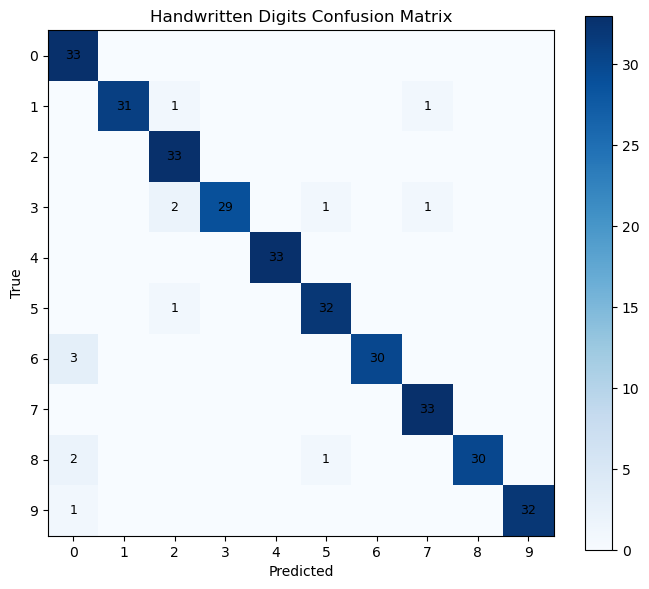

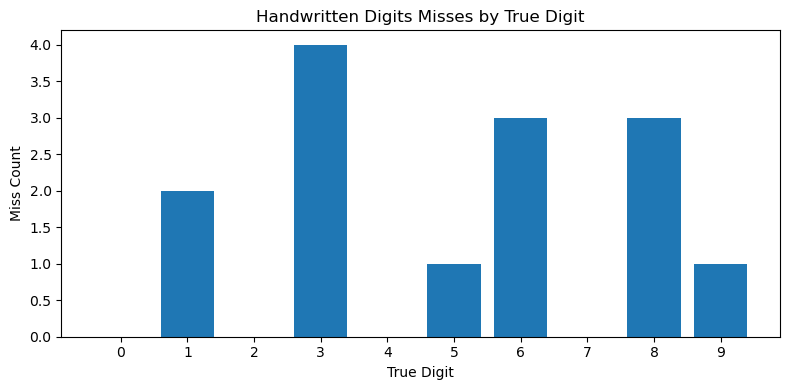

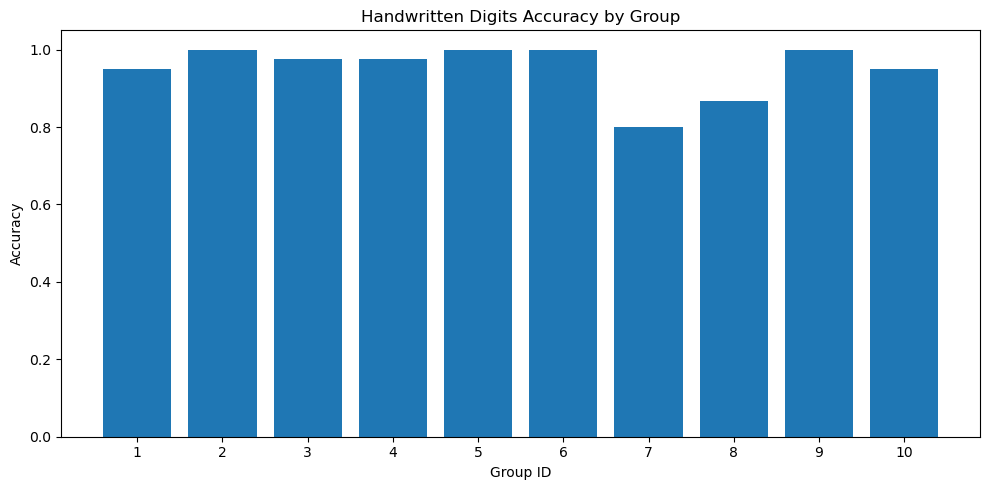


Handwritten Digits mispredictions: 14 / 330
- ./digits/1-3-2.png | true=1 pred=7
- ./digits/1-4-4.png | true=1 pred=2
- ./digits/3-1-3.png | true=3 pred=2
- ./digits/3-7-1.png | true=3 pred=7
- ./digits/3-7-2.png | true=3 pred=5
- ./digits/3-8-2.png | true=3 pred=2
- ./digits/5-8-2.png | true=5 pred=2
- ./digits/6-10-3.png | true=6 pred=0
- ./digits/6-7-2.png | true=6 pred=0
- ./digits/6-8-2.png | true=6 pred=0
- ./digits/8-1-1.png | true=8 pred=5
- ./digits/8-7-1.png | true=8 pred=0
- ./digits/8-8-2.png | true=8 pred=0
- ./digits/9-10-3.png | true=9 pred=0


In [ ]:
# ============================================================
# 5. Local handwritten digit dataset
# ============================================================


class HandwrittenDigits(Dataset):
    def __init__(self, root, transform=None):
        self.paths = sorted(glob.glob(os.path.join(root, "*.png")))
        self.transform = transform
        self.labels = [int(os.path.basename(p).split("-")[0]) for p in self.paths]

        self.group_ids = []
        for p in self.paths:
            parts = os.path.basename(p).split("-")
            if len(parts) > 1 and parts[1].isdigit():
                self.group_ids.append(int(parts[1]))
            else:
                self.group_ids.append(-1)

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        path = self.paths[idx]
        img = Image.open(path)
        img = ColorStretch(img)
        img = img.resize((28, 28))
        if self.transform is not None:
            img = self.transform(img)

        return img, self.labels[idx], torch.tensor(self.group_ids[idx]), path


digitsRoot = "../digits"
handSet = HandwrittenDigits(digitsRoot, transform)

handLoader = torch.utils.data.DataLoader(handSet, batch_size=64, shuffle=False)

print("Handwritten digits found:", len(handSet))

if len(handSet) > 0:
    EvaluateWithDetails(handLoader, "Handwritten Digits", plot=True, printMisses=True, maxMisses=50)
else:
    print("No handwritten digits found.")




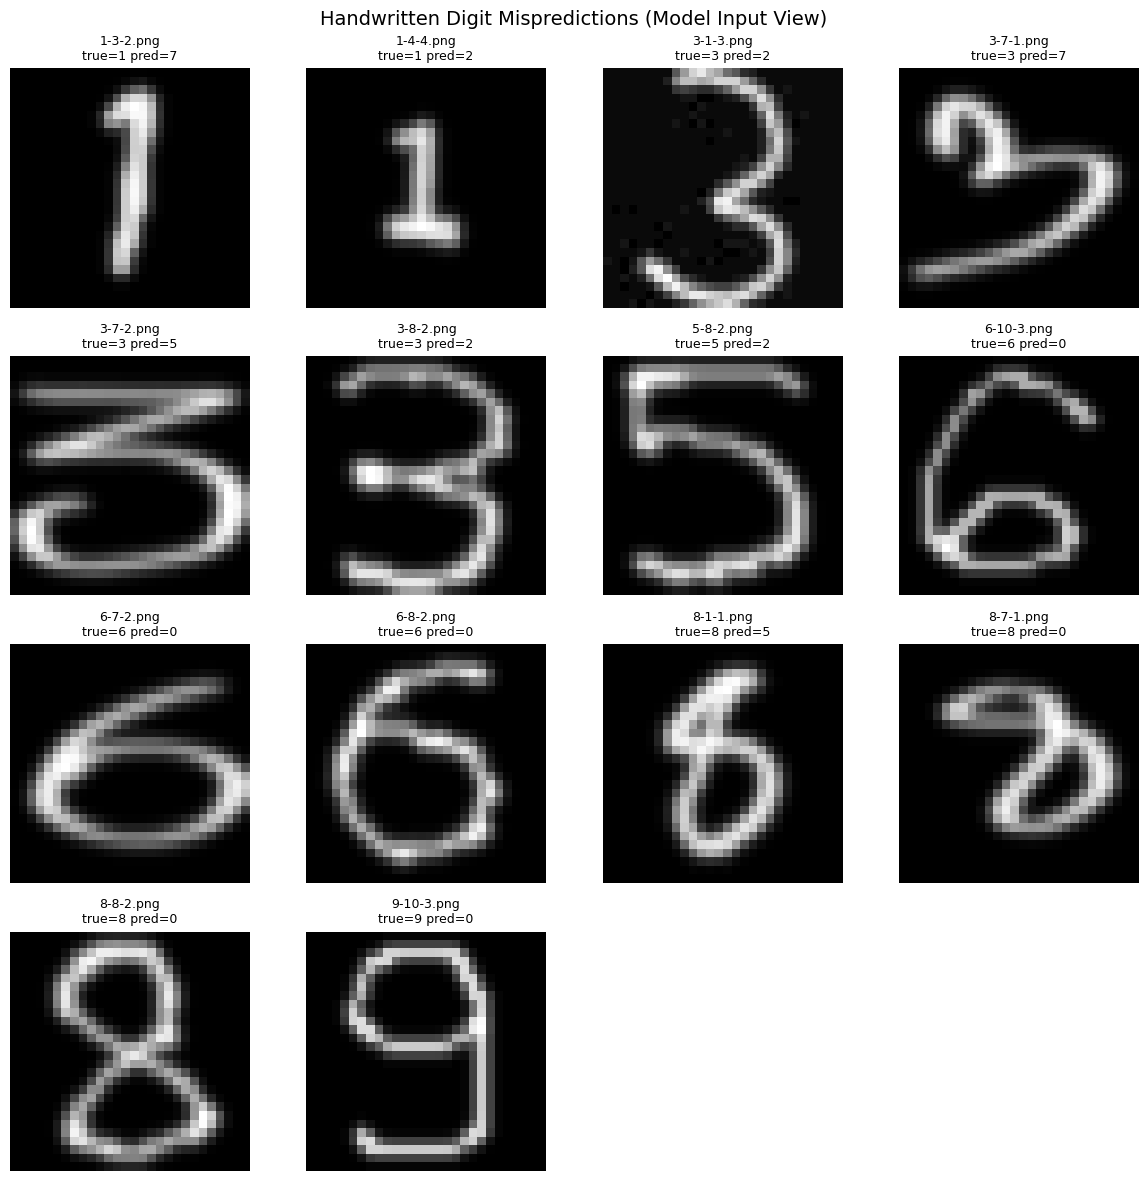

Saved: mispredictions_gallery.png


In [ ]:
import os, math
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Incorrect digits have to be entered manually.
MISSES = [
    ("./digits/1-3-2.png", 1, 7),
    ("./digits/1-4-4.png", 1, 2),
    ("./digits/3-1-3.png", 3, 2),
    ("./digits/3-7-1.png", 3, 7),
    ("./digits/3-7-2.png", 3, 5),
    ("./digits/3-8-2.png", 3, 2),
    ("./digits/5-8-2.png", 5, 2),
    ("./digits/6-10-3.png", 6, 0),
    ("./digits/6-7-2.png", 6, 0),
    ("./digits/6-8-2.png", 6, 0),
    ("./digits/8-1-1.png", 8, 5),
    ("./digits/8-7-1.png", 8, 0),
    ("./digits/8-8-2.png", 8, 0),
    ("./digits/9-10-3.png", 9, 0),
]

def _tensor_to_display_uint8(x):
    x = x.detach().cpu()
    x = (x * 0.5 + 0.5).clamp(0, 1)  # de-normalize
    return (x.squeeze().numpy() * 255).astype(np.uint8)

def MakeMispredictionGallery(misses, out_path="mispredictions_gallery.png", cols=4, dpi=300):
    n = len(misses)
    rows = math.ceil(n / cols)
    plt.figure(figsize=(cols * 3.0, rows * 3.0))

    for i, (path, y_true, y_pred) in enumerate(misses, start=1):
        ax = plt.subplot(rows, cols, i)

        if not os.path.exists(path):
            ax.set_title(f"Missing:\n{os.path.basename(path)}", fontsize=9)
            ax.axis("off")
            continue

        img = Image.open(path).convert("RGB")
        img = ColorStretch(img)
        img = img.resize((28, 28))
        x = transform(img)
        disp = _tensor_to_display_uint8(x)

        ax.imshow(disp, cmap="gray", vmin=0, vmax=255)
        ax.set_title(f"{os.path.basename(path)}\ntrue={y_true} pred={y_pred}", fontsize=9)
        ax.axis("off")

    plt.suptitle("Handwritten Digit Mispredictions (Model Input View)", fontsize=14)
    plt.tight_layout()
    plt.savefig(out_path, dpi=dpi, bbox_inches="tight")
    plt.show()
    print("Saved:", out_path)

MakeMispredictionGallery(MISSES, out_path="mispredictions_gallery.png", cols=4, dpi=300)
